In [3]:
!pip install surprise

     |████████████████████████████████| 11.8MB 9.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670917 sha256=08e347a215bc9b307c715a31c2037f0e5a285c7c6b8b3dc0f2cc391dacd0c9fc
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [4]:
# Importing Neccessary Packages:

import pandas as pd
import numpy as np
import surprise
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
import pickle
from surprise.model_selection import cross_validate, train_test_split
import warnings
warnings.filterwarnings('ignore')
import time

# Surprise Models:

from surprise import NormalPredictor, BaselineOnly
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering


In [5]:
# To mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Function to change dtype of id from string to int:
def change_type_id(x):
    try:
        return int(x)
    except ValueError:
        return None

In [7]:
# Function to create Movie Name to ID Mapper:

def get_movie_name_to_id_mapper(label = "25M"):
  if label == "25M":
    movies = pd.read_csv('/content/drive/MyDrive/USML_Data/ml-25m/movies.csv')
  elif label == "1M":
    movies = pd.read_csv("/content/drive/MyDrive/USML_Data/ml-1m/movies.dat", sep="::", usecols = [0, 1, 2], names = ['movieId', 'title', 'genres'], engine = 'python')
  else:
    print("Invalid Label!")
  movie_name_to_id_map = dict(zip(movies["title"].tolist(), movies["movieId"].tolist()))
  return movie_name_to_id_map

In [8]:
# Function to save outputs:
def write_files(data, file_name):
  data.to_csv("/content/drive/MyDrive/USML_Data/Cleaned Data/" + file_name)
  return

In [9]:
# Function to Load Datasets:

def load_data(dataset_name, loader):

  if dataset_name == "TMD":
    ratings = pd.read_csv('/content/drive/MyDrive/USML_Data/ratings.csv')
    if dataset_name == "TMD" and loader == True:
      reader = Reader(rating_scale = (0.5, 5))
      our_data_full = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
      return our_data_full
    else: return ratings

  if dataset_name == "ML1":
    ml_1m = Dataset.load_builtin("ml-1m")
    if dataset_name == "ML1" and loader == False:
      ml_1m_df = pd.DataFrame(ml_1m.raw_ratings, columns = ["userId", "movieId", "ratings", "timestamp"])
      return ml_1m_df
    else: return ml_1m

  if dataset_name == "ML25":
    ml_25m_df = pd.read_csv("/content/drive/MyDrive/USML_Data/ml-25m/ratings.csv")
    if dataset_name == "ML25" and loader == True:
      reader = Reader(rating_scale = (0.5, 5))
      ml25m_surp = Dataset.load_from_df(ml_25m_df[["userId", "movieId", "rating"]], reader)
      return ml25m_surp
    else: return ml_25m_df

  

In [10]:
# Function to get Movie and User counts on condition:

def get_movie_and_user_counts(df, min_movies, min_users):
    filtered_movies = df["movieId"].value_counts() >= min_movies
    filtered_movies = filtered_movies[filtered_movies].index.tolist()
    filtered_users = df["userId"].value_counts() >= min_users
    filtered_users = filtered_users[filtered_users].index.tolist()
    print("Len of Filtered Users: {}, Len of Filtered Movies: {}".format(len(filtered_users), len(filtered_movies)))

    return filtered_users, filtered_movies

In [11]:
# Function to run Surprise Models:

def run_surprise_models(algo_list, data):
  benchmark = list()
  for algo in algo_list:
    results = cross_validate(algo, data, 
                            measures = ["RMSE", "MAE", "MSE", "FCP"],
                            cv = 5, 
                            verbose = True)
    temp_res = pd.DataFrame.from_dict(results).mean(axis = 0)
    temp_res = temp_res.append(pd.Series([str(algo).split(" ")[0].split(".")[-1]], index = ["Algorithm"]))
    benchmark.append(temp_res)

    test_results = pd.DataFrame(benchmark).set_index("Algorithm").sort_values("test_rmse")
    test_results
  
  return results, benchmark, test_results

In [12]:
# Function for Hyperparameter Tuning:

def hyperparameter_tuning(algo, param_grid, data, measure = "rmse", cv = 5):
  start = time.time()
  hyper_tuner = GridSearchCV(algo, param_grid, measures=['rmse', "mae"], cv = cv, n_jobs = -1, joblib_verbose = 1)
  hyper_tuner.fit(data)
  print(hyper_tuner.best_score[measure])
  print(hyper_tuner.best_params[measure])

  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Hypertuning: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

  return hyper_tuner, hyper_tuner.best_params[measure]

In [13]:
# Function to Predict User Ratings:

def predict_user_ratings(userid, data, movie_id_mapper, algo):
    if userid in data["userId"].unique():
        ui_list = data[data["userId"] == userid]["movieId"].tolist()
        d = {k: v for k,v in movie_id_mapper.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algo.predict(userid, j)
            predictedL.append((i, predicted[3])) 
        preds_df = pd.DataFrame(predictedL, columns = ['Movies', 'Ratings'])
        preds_df.sort_values('Ratings', ascending=False, inplace=True)  
        # preds_df.set_index('Movies', inplace=True) 
        print("\nPredictions for UserId: {}".format(userid))
        print("============================================================\n")
        print(preds_df.head(10))  
        print("============================================================\n") 
        return preds_df.head(10)        
    else:
        print("UserID: {} does not exist in the list!".format(userId))
        return None

In [14]:
# Function to Train Models:

def train_model(data, model):
  start = time.time()
  trainset, testset = train_test_split(ml25m_surp, test_size = 20)
  print("# of users in train: {} \t # of items in train: {}\t # of ratings in train: {}".format(trainset.n_users, trainset.n_items, trainset.n_ratings))
  model.fit(trainset)
  predictions = model.test(testset)
  rmse = accuracy.rmse(predictions, verbose = True)
  # print("RMSE: {:.4f}".format(rmse))
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Training: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  return predictions, rmse

In [15]:
# Function to Display Predictions
def display_predictions(userids, data, model, movie_mapper_label):
  movie_name_to_id_map = get_movie_name_to_id_mapper(movie_mapper_label)
  for uid in userids:
    predict_user_ratings(uid, data, movie_name_to_id_map, model)
  return

In [16]:
# Importing Data:

ratings = load_data("TMD", False)
ml1m_df = load_data("ML1", False)
ml25m_df = load_data("ML25", False)
ml1m_surp = load_data("ML1", True)
ml25m_surp = load_data("ML25", True)

Dataset ml-1m could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /root/.surprise_data/ml-1m


In [15]:
print("Size of The Movies Dataset:{}\nSize of MovieLens 1M: {}\nSize of MovieLens 25M: {}".format(ratings.shape, ml1m_df.shape, ml25m_df.shape))

Size of The Movies Dataset:(26024289, 4)
Size of MovieLens 1M: (1000209, 4)
Size of MovieLens 25M: (25000095, 4)


Text(0, 0.5, 'Counts')

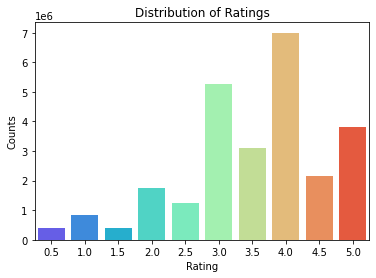

In [ ]:
# Visualizing Distribution of Ratings in The Movies Dataset:

sns.countplot(ratings["rating"], palette = "rainbow")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

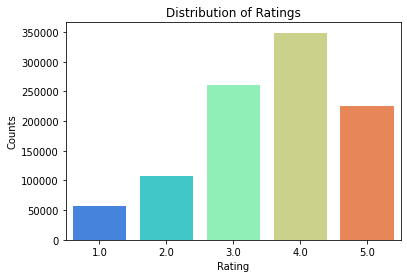

In [ ]:
# Visualizing Distribution of Ratings in The Movies Dataset:

sns.countplot(ml1m_df["ratings"], palette = "rainbow")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

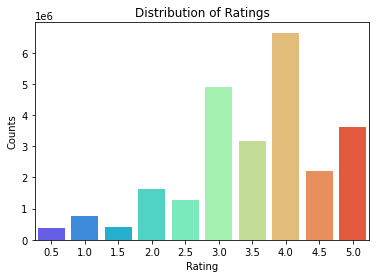

In [ ]:
# Visualizing Distribution of Ratings in The Movies Dataset:

sns.countplot(ml25m_df["rating"], palette = "rainbow")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Counts")

In [12]:
# Filtering Users such that they have rated atleast 20 movies:

filtered_users_r, filtered_movies_r = get_movie_and_user_counts(ratings, 0, 20)
filtered_users, filtered_movies = get_movie_and_user_counts(ml1m_df, 0, 20)
filtered_users, filtered_movies = get_movie_and_user_counts(ml25m_df, 0, 20)

Len of Filtered Users: 166444, Len of Filtered Movies: 45115
Len of Filtered Users: 3043, Len of Filtered Movies: 6040
Len of Filtered Users: 162541, Len of Filtered Movies: 59047


In [13]:
# Filtering Dataset such that every user has rated atleast 20 movies.

our_data_modified_df = ratings[(ratings["movieId"].isin(filtered_movies_r)) & (ratings["userId"].isin(filtered_users_r))]
print("Old Size: {}\t New Size: {}".format(ratings.shape, our_data_modified_df.shape))
reader = Reader(rating_scale = (0.5, 5))
our_data_modified = Dataset.load_from_df(our_data_modified_df[["userId", "movieId", "rating"]], reader)

Old Size: (26024289, 4)	 New Size: (24848104, 4)


#### Running all Algorithms on MovieLens 1 Million

In [ ]:
# Running Surprise Collaborative Filtering Models on Movie Lens 1M:

algo_list = [SVD(), NMF(), NormalPredictor(), BaselineOnly(), 
             KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), 
             SlopeOne(), CoClustering()]

results, benchmark, test_results = run_surprise_models(algo_list, ml1m_surp)
write_files(test_results, "ml1m_surprise_all_models.csv")

Evaluating RMSE, MAE, MSE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8735  0.8755  0.8740  0.8742  0.8740  0.8742  0.0007  
MAE (testset)     0.6854  0.6875  0.6857  0.6868  0.6863  0.6863  0.0008  
MSE (testset)     0.7630  0.7665  0.7638  0.7643  0.7638  0.7643  0.0012  
FCP (testset)     0.7464  0.7458  0.7467  0.7436  0.7438  0.7453  0.0013  
Fit time          45.51   45.78   45.80   46.00   49.15   46.45   1.36    
Test time         5.93    4.52    4.43    5.69    4.77    5.07    0.62    
Evaluating RMSE, MAE, MSE, FCP of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9161  0.9168  0.9151  0.9172  0.9169  0.9164  0.0008  
MAE (testset)     0.7242  0.7245  0.7236  0.7250  0.7232  0.7241  0.0007  
MSE (testset)     0.8392  0.8406  0.8374  0.8413  0.8407  0.8398  0.0014  
FCP (testset)     0.7194  0.7210  0.7203  0.718

#### SVD on "The Movies Dataset"

In [30]:
# Running SVD on The Movies Dataset:

algo_list = [SVD()]
results, benchmark, test_results = run_surprise_models(algo_list, our_data_modified)
write_files(test_results, "tmd_surprise_SVD_new.csv")

Evaluating RMSE, MAE, MSE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7813  0.7815  0.7815  0.7819  0.7816  0.7815  0.0002  
MAE (testset)     0.5912  0.5912  0.5913  0.5915  0.5915  0.5913  0.0001  
MSE (testset)     0.6104  0.6107  0.6108  0.6114  0.6108  0.6108  0.0003  
FCP (testset)     0.7479  0.7480  0.7469  0.7478  0.7474  0.7476  0.0004  
Fit time          1216.84 1241.07 1241.61 1230.60 1227.75 1231.57 9.21    
Test time         184.77  263.09  212.89  156.41  214.54  206.34  35.47   


## ON MOVIE LENS 25 MILLION:

In [ ]:
# Running SVD on Movie Lens 25M:

algo_list = [SVD()]
results, benchmark, test_results = run_surprise_models(algo_list, ml25m_surp)
write_files(test_results, "ml25m_surprise_SVD_new.csv")

Evaluating RMSE, MAE, MSE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7784  0.7776  0.7779  0.7774  0.7777  0.7778  0.0003  
MAE (testset)     0.5871  0.5870  0.5869  0.5867  0.5867  0.5869  0.0002  
MSE (testset)     0.6059  0.6047  0.6051  0.6044  0.6048  0.6050  0.0005  
FCP (testset)     0.7425  0.7430  0.7430  0.7433  0.7427  0.7429  0.0003  
Fit time          1210.37 1229.02 1258.57 1251.89 1223.73 1234.72 17.94   
Test time         151.00  142.76  163.37  108.47  131.67  139.45  18.64   


#### Hypertuning SVD on Movie Lens 1M: (Very Computationally Expensive)
##### Takes over 16 hours to complelte





In [ ]:
# Hypertuning SVD on Movie Lens 1M Dataset:

param_grid = {'n_factors': [20, 50, 100, 150, 200], 
              'n_epochs': [5, 10, 15, 20, 25], 
              'lr_all': [0.01, 0.02, 0.03, 0.05, 0.002, 0.003, 0.005],
              'reg_all': [0.2, 0.4, 0.6, 0.8]}

hyper_tuner, best_params = hyperparameter_tuning(SVD, param_grid, ml1m_surp, measure = "rmse", cv = 5)
print("Best Parameters: \n\n{}".format(best_params))

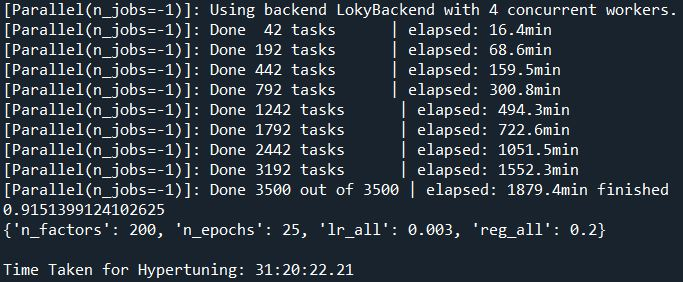

#### Training SVD and then making Predictions on User Ids:

In [16]:
# Training SVD:

svd = SVD()
predictions, rmse = train_model(ml25m_surp, svd)

# of users in train: 162541 	 # of items in train: 59047	 # of ratings in train: 25000075
RMSE: 0.5745

Time Taken for Training: 00:30:00.98


In [17]:
userids = [1, 54, 777, 982]
display_predictions(userids, ml25m_df, svd, "25M")


Predictions for UserId: 1

                                            Movies   Ratings
2745                        American Beauty (1999)  4.658104
26660  Louis C.K.: Live at The Comedy Store (2015)  4.578219
36942        Requiem for the American Dream (2015)  4.567810
758                           Trainspotting (1996)  4.554061
4743                           Donnie Darko (2001)  4.538798
2287                               Rushmore (1998)  4.522521
40697                 O.J.: Made in America (2016)  4.511944
42517                       Horace and Pete (2016)  4.506180
16241                 Louis C.K.: Hilarious (2010)  4.502333
49                      Usual Suspects, The (1995)  4.496782


Predictions for UserId: 54

                                                  Movies   Ratings
45901                                             Cosmos  4.720490
45669                             Planet Earth II (2016)  4.718451
40537                                        Life (2009)  4.709211
221

In [19]:
svd_tuned = SVD(n_factors = 200, n_epochs = 25, lr_all = 0.003, reg_all = 0.2)
predictions, rmse = train_model(ml25m_surp, svd_tuned)

# of users in train: 162541 	 # of items in train: 59047	 # of ratings in train: 25000075
RMSE: 1.1336

Time Taken for Training: 00:58:55.69
